# Klasifikasi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

### Data dapat diunduh di https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets

### Data tidak memiliki Missing Values

In [3]:
df_train = pd.read_csv('train.csv',delimiter=';')
df_test=pd.read_csv('test.csv',delimiter=';')

In [4]:
display(df_train.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


# One hot Encoding

In [6]:
cat=df_train.select_dtypes('object').columns.to_numpy()

In [7]:
print(cat)

['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome' 'y']


In [8]:
for i in cat:
    df_train= pd.get_dummies(df_train, columns=[i])
    df_test= pd.get_dummies(df_test, columns=[i])

In [9]:
df_train.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_no,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,33,2,5,76,1,-1,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0
3,47,1506,5,92,1,-1,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


# Feature Selection

In [10]:
def get_IV(df, feature, target):
    lst = []
    unique_values = df[feature].unique()
    for val in unique_values:
        lst.append([feature,                                                        
                    val,                                                            
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]   
                   ])
 
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'Good', 'Bad'])

        
    total_bad = df[df[target] == 0].count()[feature]
    total_good = df.shape[0] - total_bad
    
    data['Distribution Good'] = data['Good']/ total_good
    data['Distribution Bad'] = data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    iv = data['IV'].sum()

    return iv, data

In [29]:
%%time

x=df_train.columns.to_numpy()
ivarr=[]
ivcol=[]

for i in x:
    iv,data = get_IV(df_train, i, 'y_yes')
    ivarr.append(iv)
    ivcol.append(i)

Wall time: 22 s


In [12]:
i_values = pd.DataFrame({'column':ivcol,'information_value':ivarr})

In [13]:
display(i_values)

,column,information_value
0,age,2.230604e-01
1,balance,7.052744e-01
2,day,1.177583e-01
3,duration,1.135313e+00
4,campaign,7.997797e-02
5,pdays,4.949138e-01
6,previous,2.290430e-01
7,job_admin.,3.027960e-04
8,job_blue-collar,5.866439e-02
9,job_entrepreneur,4.319891e-03


### Dipilih IV>0.1 dan IV<0.5

In [14]:
setelah= i_values['information_value']>=0.1
sebelum = i_values['information_value']<=0.5
i_value= i_values.loc[setelah & sebelum]
i_value = i_value.sort_values(by=['information_value'],ascending=False)

In [15]:
display(i_value)

,column,information_value
5,pdays,0.494914
49,poutcome_success,0.483683
34,contact_unknown,0.299443
6,previous,0.229043
0,age,0.223060
50,poutcome_unknown,0.218678
32,contact_cellular,0.212207
28,housing_no,0.188681
29,housing_yes,0.188681
43,month_may,0.118166


In [16]:
fitur = i_value['column'].to_numpy()
X_train = df_train[fitur]
y_train = df_train['y_yes'] 

X_test=df_test[fitur]
y_test=df_test['y_yes']

# Scoring

In [2]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Naive Bayes

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 85.18
Time consumed for training: 0.033 seconds
Time consumed for prediction: 0.00377 seconds
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4000
           1       0.33      0.27      0.29       521

    accuracy                           0.85      4521
   macro avg       0.62      0.60      0.61      4521
weighted avg       0.84      0.85      0.85      4521



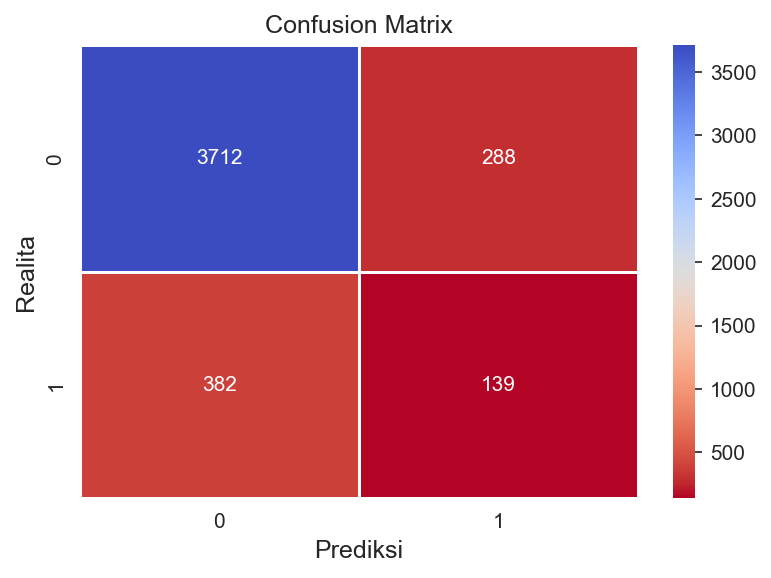

In [17]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.naive_bayes import GaussianNB


scaler_gnb = MaxAbsScaler()
gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = gnb.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-NB.png')

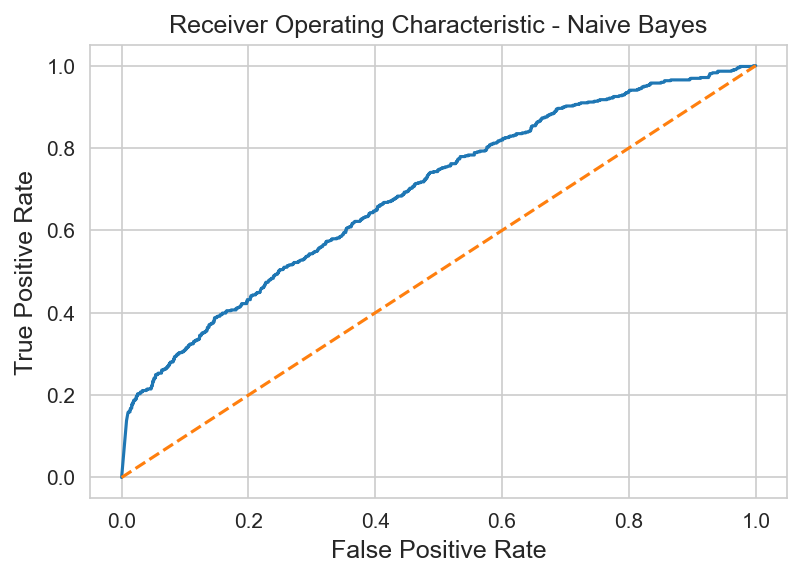

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score = gnb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

#plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_NB.png',dpi=100)
plt.show()

# XGBOOST

[11:36:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 90.84
Time consumed for training: 0.793
Time consumed for prediction: 0.05185 seconds
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4000
           1       0.85      0.25      0.39       521

    accuracy                           0.91      4521
   macro avg       0.88      0.62      0.67      4521
weighted avg       0.90      0.91      0.89      4521



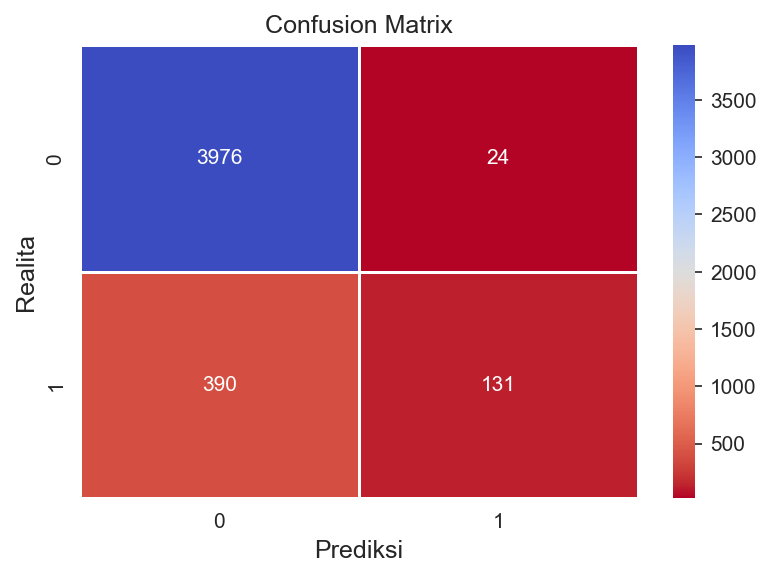

In [19]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

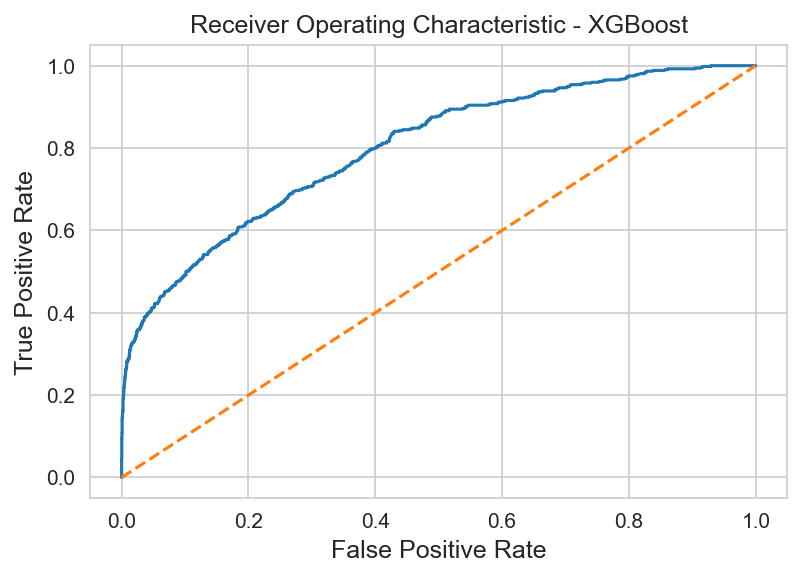

In [20]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

# Random Forest

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 92.88
Time consumed for training: 0.293 seconds
Time consumed for prediction: 0.07264 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4000
           1       0.86      0.45      0.59       521

    accuracy                           0.93      4521
   macro avg       0.90      0.72      0.78      4521
weighted avg       0.93      0.93      0.92      4521



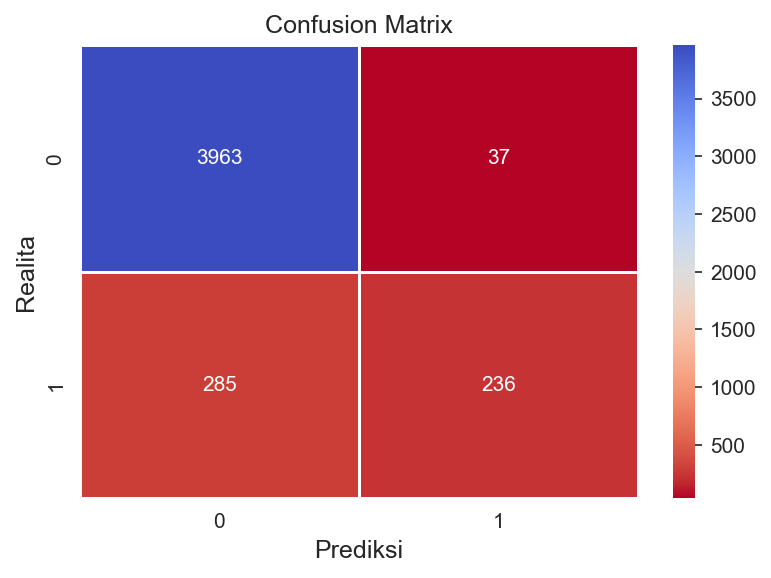

In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

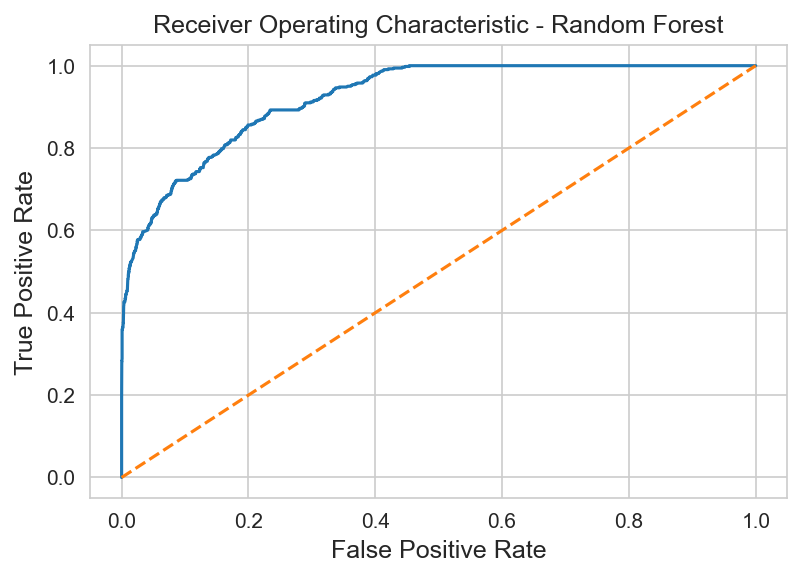

In [22]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

# SVM

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 88.48
Time consumed for training: 164.432 seconds
Time consumed for prediction: 4.13024 seconds
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      4000
           1       0.00      0.00      0.00       521

    accuracy                           0.88      4521
   macro avg       0.44      0.50      0.47      4521
weighted avg       0.78      0.88      0.83      4521



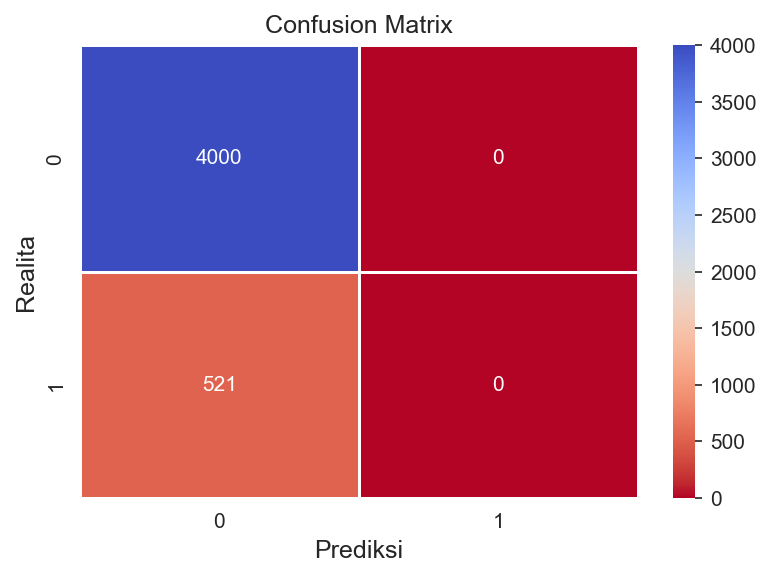

In [23]:
from sklearn.svm import SVC
svc = SVC(probability=True)
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-SVM.png')

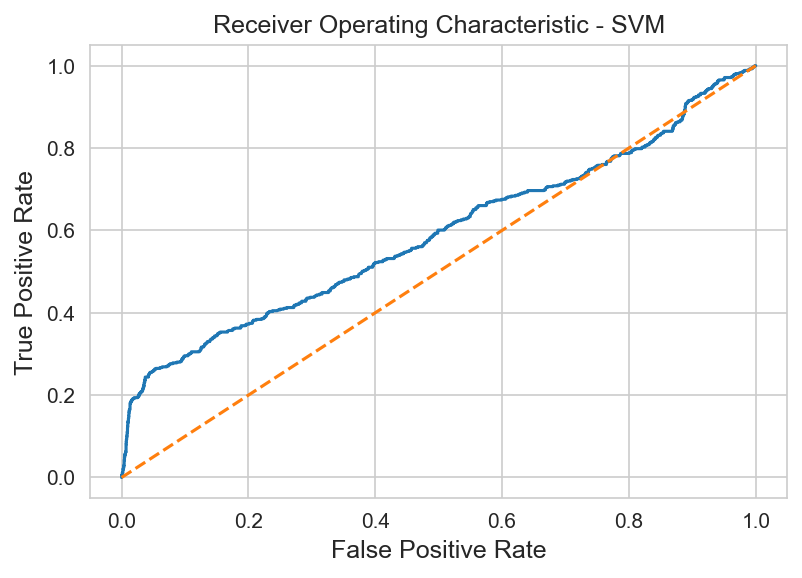

In [24]:
y_score = svc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_SVM.png',dpi=100)
plt.show()

# Logistic Regression

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 89.34
Time consumed for training: 1.334 seconds
Time consumed for prediction: 0.00006 seconds
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4000
           1       0.65      0.16      0.26       521

    accuracy                           0.89      4521
   macro avg       0.78      0.57      0.60      4521
weighted avg       0.87      0.89      0.86      4521



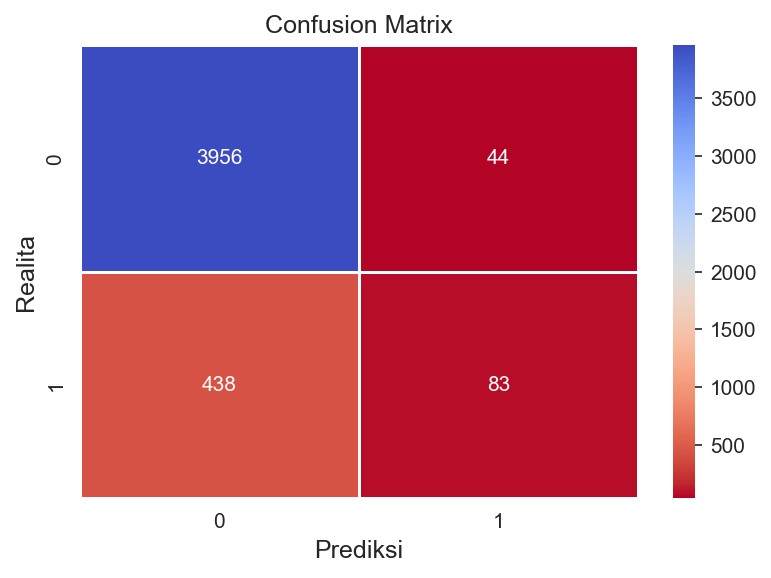

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


training_start = time.perf_counter()
logreg = LogisticRegression(class_weight='auto',max_iter=1000)
model=logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction_end = time.perf_counter()
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
logreg_train_time = training_end-training_start
logreg_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Time consumed for training: %4.3f seconds" % (logreg_train_time))
print("Time consumed for prediction: %6.5f seconds" % (logreg_prediction_time))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

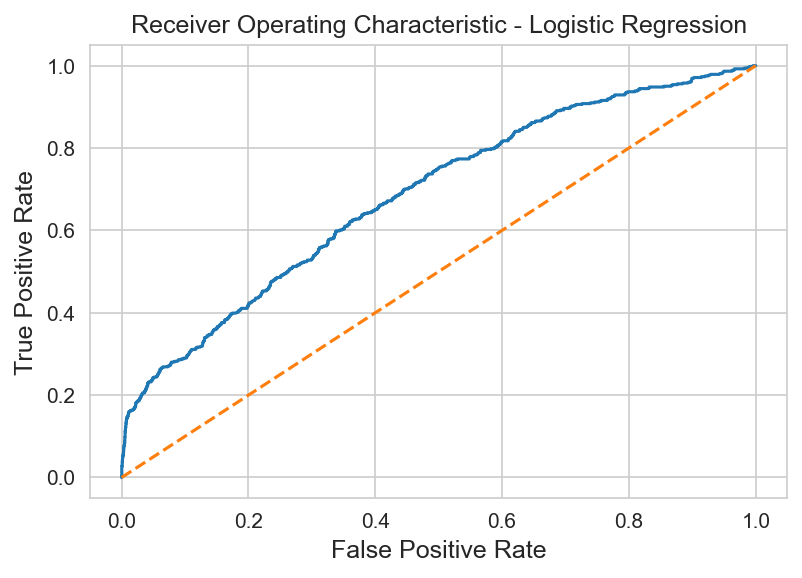

In [28]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [26]:
results = pd.DataFrame({
    'Model': [ 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC','Logistic Regression'],
    'Score': [acc_gnb, acc_xgb, acc_rfc, acc_svc,acc_logreg],
    'Runtime Training': [gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time,logreg_train_time],
    'Runtime Prediction': [gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time,logreg_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,92.877682,0.293328,0.072644
XGBoost,90.842734,0.792783,0.051852
Logistic Regression,89.338642,1.333593,0.000057
SVC,88.476001,164.432405,4.130242
Naive Bayes,85.180270,0.033343,0.003768


# Parameter Tuning

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
%%time

from sklearn.model_selection import GridSearchCV
param_test = {
    'reg_alpha':[1e-3,1e-2,1e-1]
}
gsearch = GridSearchCV(estimator = XGBClassifier(eval_metric='logloss'), 
              param_grid = param_test,
              scoring='accuracy',n_jobs=4,
              cv=10)

gsearch.fit(X_train,y_train)

print('Best Grid Search Parameters :',gsearch.best_params_)
print('Best Grid Search Score : ',gsearch.best_score_)

Best Grid Search Parameters : {'reg_alpha': 0.001}
Best Grid Search Score :  0.5986533285475683
Wall time: 18.8 s


In [32]:
xgbl=XGBClassifier()
xgbl.fit(X_train,y_train)

[10:26:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
y_pred=gsearch.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print('accuracy setelah parameter tuning:',acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print('accuracy sebelum parameter tuning:',acc_xgb)

accuracy setelah parameter tuning: 90.88697190886973
accuracy sebelum parameter tuning: 90.84273390842735


In [34]:
%%time

param_test1 = {
 'max_depth':[5,6,7],
 'min_child_weight':[1,2,3]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(eval_metric='logloss'), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=20)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Wall time: 1min 58s


({'max_depth': 5, 'min_child_weight': 1}, 0.6383241419530086)

In [35]:
y_pred=gsearch1.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print('accuracy setelah parameter tuning:',acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print('accuracy sebelum parameter tuning:',acc_xgb)

accuracy setelah parameter tuning: 90.59942490599425
accuracy sebelum parameter tuning: 90.84273390842735


In [36]:
param_test2 = {
 'gamma':[10**(-i) for i in range(3,6)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(eval_metric='logloss'), 
 param_grid = param_test2, scoring='accuracy', cv=10)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.001}, 0.5909780354708154)

In [37]:
y_pred=gsearch2.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)

90.84273390842735
90.84273390842735


In [38]:
%%time

param_test3 = {
'subsample':[0.99,1,1.01]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(eval_metric='logloss'), 
 param_grid = param_test3, scoring='accuracy', cv=10)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Wall time: 16.6 s


({'subsample': 1}, 0.590933797470373)

In [39]:
y_pred=gsearch3.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)

90.84273390842735
90.84273390842735


In [40]:
%%time


param_test4 = { 'colsample_bytree':[0,1,2]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(eval_metric='logloss'), 
 param_grid = param_test4, scoring='accuracy', cv=10)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch3.best_score_



Wall time: 10.1 s


({'colsample_bytree': 0}, 0.590933797470373)

In [41]:
y_pred=gsearch4.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)

89.73678389736784
90.84273390842735


In [42]:
from sklearn.model_selection import RandomizedSearchCV
params={'max_depth':[i for i in range(9,11)]}
search = GridSearchCV(xgb, params, scoring='accuracy', n_jobs=4, cv=10)

In [43]:
%%time
result=search.fit(X_train,y_train)

[10:29:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 21.2 s


In [44]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5753620213146551
Best Hyperparameters: {'max_depth': 9}


In [45]:
y_pred=result.best_estimator_.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)
y_pred=xgbl.predict(X_test)
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgb)

92.0150409201504
90.84273390842735


# Threshold Tuning

In [46]:
def threshold(classifier):
    acc=[]
    rec=[]
    prec=[]
    roc_auc=[]
    f1=[]
    threshold=[i/20 for i in range(1,20)]
    for i in threshold:
        preds = np.where(classifier.predict_proba(X_test)[:,1] >= i, 1, 0)
        acc.append(metrics.accuracy_score(y_test, preds))
        rec.append(metrics.recall_score(y_test, preds))
        prec.append(metrics.precision_score(y_test, preds,zero_division=1))
        roc_auc.append(metrics.roc_auc_score(y_test, preds))
        f1.append(metrics.f1_score(y_test, preds))
    threshold = pd.DataFrame({'Threshold':threshold,'Accuracy':acc,'Precision':prec,'recall':rec,'roc_auc':roc_auc,'f1_score':f1})
    display(threshold)

In [47]:
threshold(rfc)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.638797,0.239212,0.978887,0.786693,0.384470
1,0.10,0.728600,0.283436,0.886756,0.797378,0.429568
2,0.15,0.837425,0.396718,0.788868,0.816309,0.527938
3,0.20,0.870825,0.460576,0.706334,0.799292,0.557576
4,0.25,0.908206,0.594306,0.641075,0.792037,0.616805
5,0.30,0.916390,0.647423,0.602687,0.779969,0.624254
6,0.35,0.928334,0.757180,0.556622,0.766686,0.641593
7,0.40,0.932095,0.811047,0.535509,0.759629,0.645087
8,0.45,0.933422,0.864238,0.500960,0.745355,0.634265
9,0.50,0.932758,0.897436,0.470250,0.731625,0.617128


In [48]:
threshold(xgb)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.423800,0.157912,0.923225,0.640987,0.269694
1,0.10,0.710905,0.241107,0.702495,0.707248,0.359000
2,0.15,0.831896,0.351183,0.541267,0.705508,0.425982
3,0.20,0.872152,0.446125,0.452975,0.689863,0.449524
4,0.25,0.892723,0.547368,0.399232,0.678116,0.461709
5,0.30,0.900464,0.614887,0.364683,0.667467,0.457831
6,0.35,0.904667,0.673077,0.335893,0.657321,0.448143
7,0.40,0.908870,0.753488,0.310940,0.648845,0.440217
8,0.45,0.909754,0.815642,0.280230,0.635990,0.417143
9,0.50,0.908427,0.845161,0.251440,0.622720,0.387574


In [49]:
threshold(logreg)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.313426,0.134860,0.915547,0.575274,0.235091
1,0.10,0.581509,0.170591,0.681382,0.624941,0.272867
2,0.15,0.775935,0.229075,0.399232,0.612116,0.291113
3,0.20,0.882327,0.473171,0.186180,0.579590,0.267218
4,0.25,0.892944,0.643411,0.159309,0.573905,0.255385
5,0.30,0.892944,0.643411,0.159309,0.573905,0.255385
6,0.35,0.893386,0.653543,0.159309,0.574155,0.256173
7,0.40,0.893386,0.653543,0.159309,0.574155,0.256173
8,0.45,0.893386,0.653543,0.159309,0.574155,0.256173
9,0.50,0.893386,0.653543,0.159309,0.574155,0.256173


In [50]:
threshold(svc)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.115240,0.115240,1.000000,0.500000,0.206664
1,0.10,0.117452,0.115154,0.996161,0.499581,0.206444
2,0.15,0.891396,0.629310,0.140115,0.564683,0.229199
3,0.20,0.884760,0.500000,0.019194,0.508347,0.036969
4,0.25,0.884981,0.526316,0.019194,0.508472,0.037037
5,0.30,0.885202,0.555556,0.019194,0.508597,0.037106
6,0.35,0.885202,0.555556,0.019194,0.508597,0.037106
7,0.40,0.884760,0.500000,0.015355,0.506678,0.029795
8,0.45,0.884539,0.466667,0.013436,0.505718,0.026119
9,0.50,0.884539,0.461538,0.011516,0.504883,0.022472


In [51]:
threshold(gnb)

,Threshold,Accuracy,Precision,recall,roc_auc,f1_score
0,0.05,0.603406,0.174180,0.652591,0.624796,0.274970
1,0.10,0.708472,0.201498,0.516315,0.624907,0.289871
2,0.15,0.780358,0.236018,0.404990,0.617120,0.298233
3,0.20,0.805353,0.259060,0.370441,0.616221,0.304897
4,0.25,0.814643,0.265879,0.345489,0.610620,0.300501
5,0.30,0.823048,0.273906,0.324376,0.606188,0.297012
6,0.35,0.833444,0.289855,0.307102,0.604551,0.298229
7,0.40,0.843176,0.310484,0.295585,0.605043,0.302852
8,0.45,0.847600,0.317391,0.280230,0.600865,0.297655
9,0.50,0.851803,0.325527,0.266795,0.597397,0.293249


# Model Interpretability

In [52]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.loc[[0]])


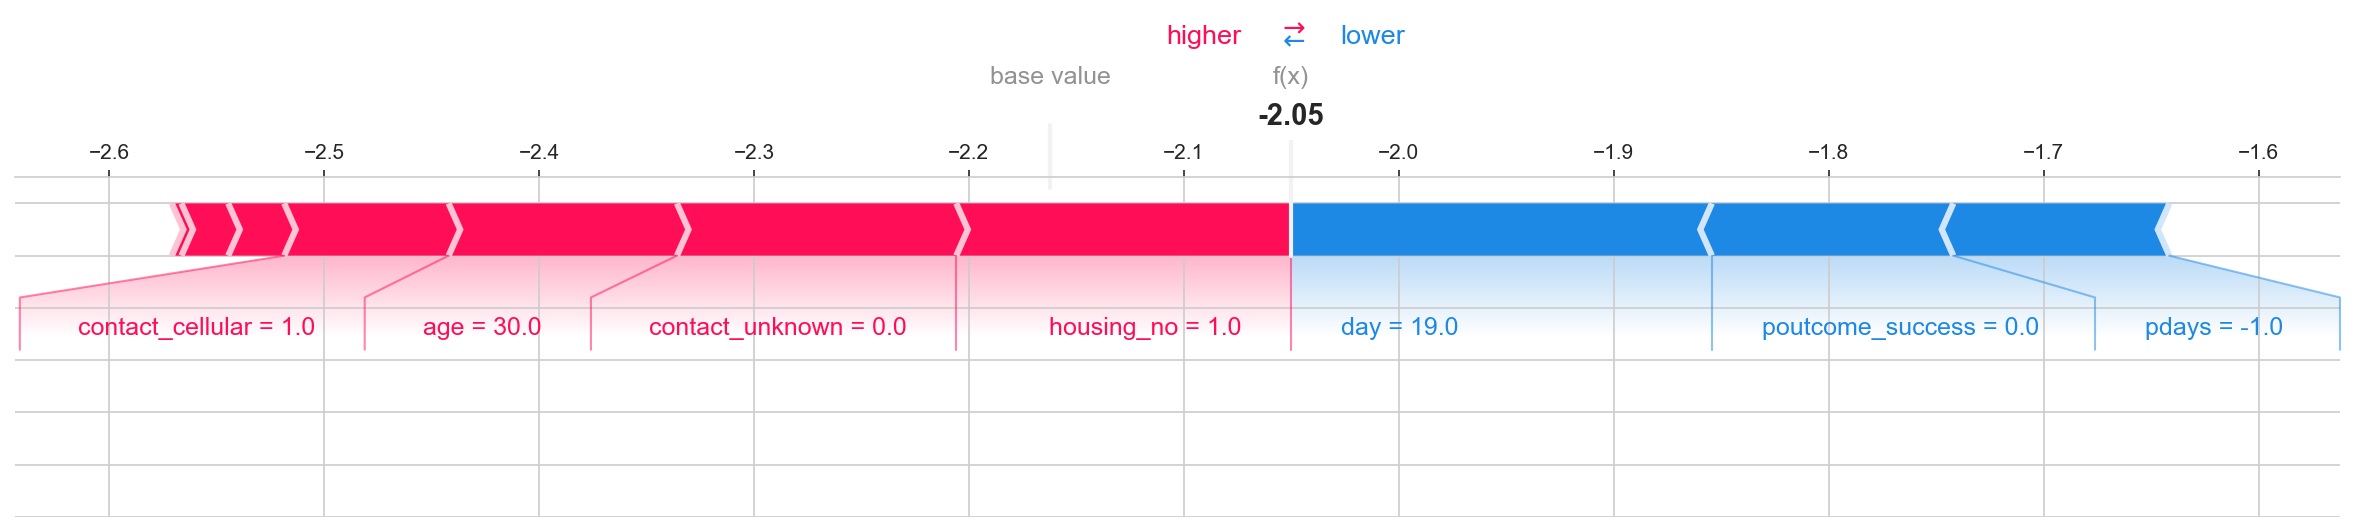

In [53]:
# visualize the first prediction's explaination with default colors
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],show=False,matplotlib=True)
plt.savefig('shapxgb.png',bbox_inches='tight')

In [54]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test.loc[[0]])

# visualize the first prediction's explaination with default colors

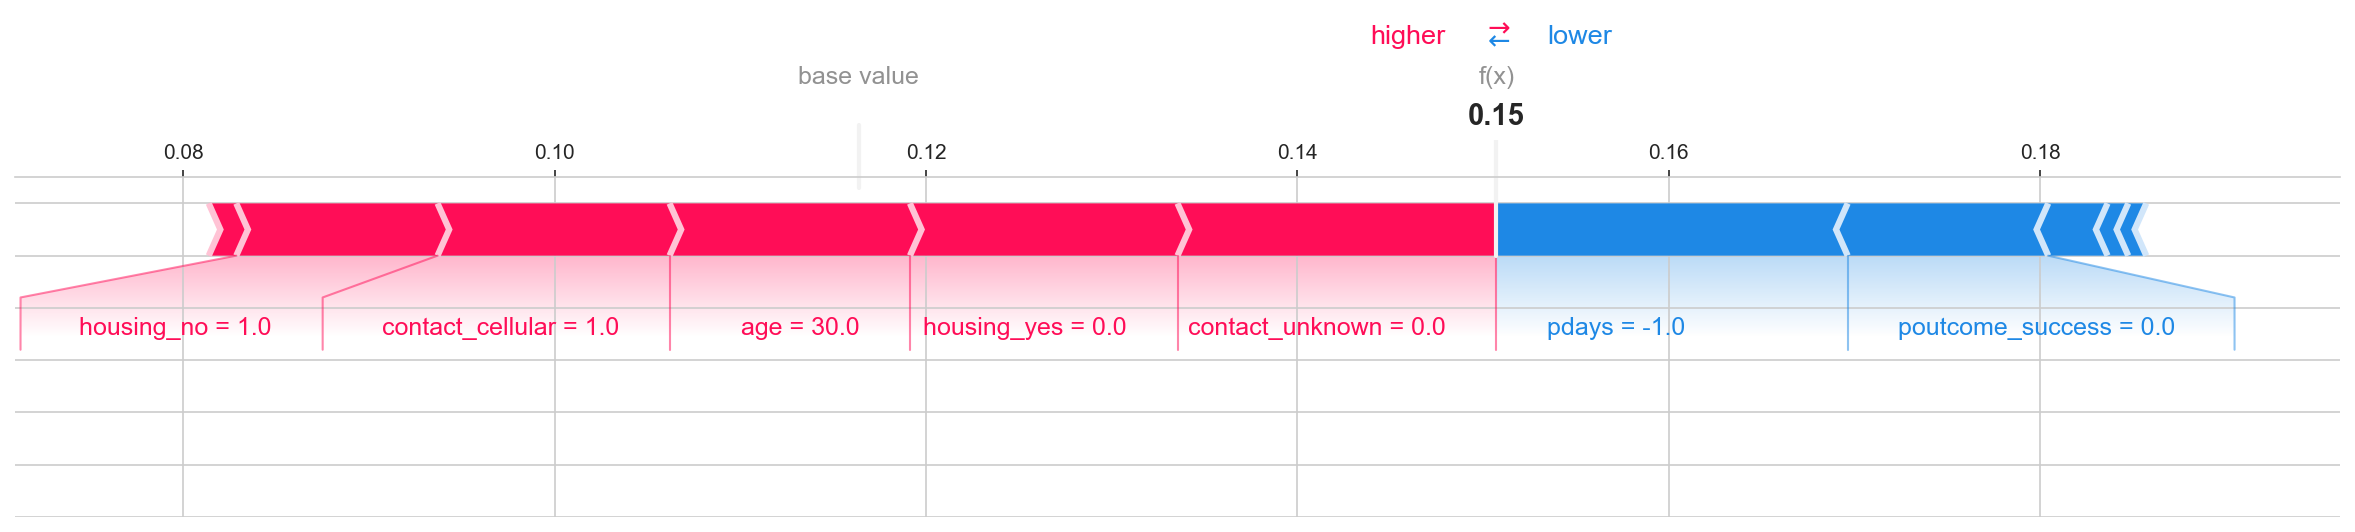

In [55]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0,:],show=False,matplotlib=True)
plt.savefig('shaprfc.png', bbox_inches='tight')

In [56]:
#explainer = shap.Explainer(logreg, X_train)
#shap_values = explainer(X_test)

In [57]:
#shap.force_plot(explainer.expected_value, shap_values[1][0], X_test.iloc[0,:])

In [3]:
#print(explainer.expected_value)

# K-Fold Cross Validation

In [59]:
from sklearn.model_selection import cross_validate as cvs
def crossval(model):
    cvscore = cvs(estimator=model,X=X_train,y=y_train,cv=10,scoring=['accuracy','precision','recall','f1','average_precision','roc_auc'])
    score_table=pd.DataFrame(cvscore)
    score_table.index+=1
    display(score_table)

In [60]:
crossval(gnb)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.015999,0.016051,0.883016,0.000000,0.000000,0.000000,0.473685,0.637485
2,0.008002,0.007983,0.883212,0.000000,0.000000,0.000000,0.998762,0.999640
3,0.007949,0.016067,0.887414,1.000000,0.037807,0.072860,0.950064,0.967581
4,0.007973,0.016006,0.892944,1.000000,0.085066,0.156794,0.437727,0.730152
5,0.015993,0.007971,0.901128,1.000000,0.155009,0.268412,0.250019,0.340643
6,0.017264,0.007995,0.894492,0.626214,0.243856,0.351020,0.344079,0.574647
7,0.016084,0.008139,0.818403,0.317500,0.480151,0.382242,0.398543,0.761101
8,0.016019,0.008026,0.715992,0.239476,0.655955,0.350859,0.521058,0.799821
9,0.015980,0.008013,0.616457,0.180710,0.644612,0.282285,0.470670,0.767309
10,0.015986,0.007981,0.635479,0.203812,0.727788,0.318445,0.310804,0.754614


In [61]:
crossval(rfc)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.210204,0.015999,0.883016,0.000000,0.000000,0.000000,0.118658,0.500444
2,0.200006,0.024041,0.174519,0.001866,0.011364,0.003205,0.077323,0.070945
3,0.201149,0.016000,0.313869,0.008031,0.039698,0.013359,0.076634,0.098385
4,0.208006,0.016005,0.762221,0.100877,0.130435,0.113768,0.110248,0.486230
5,0.191983,0.026798,0.623313,0.012458,0.028355,0.017311,0.093590,0.215916
6,0.201610,0.023992,0.823933,0.151436,0.109641,0.127193,0.130275,0.484683
7,0.200010,0.023947,0.835656,0.264317,0.226843,0.244151,0.196043,0.598215
8,0.207999,0.032000,0.703384,0.154174,0.342155,0.212566,0.141906,0.574955
9,0.191999,0.024004,0.175625,0.041308,0.272212,0.071731,0.069681,0.137723
10,0.200001,0.024000,0.455873,0.140410,0.712665,0.234599,0.155340,0.599985


In [62]:
crossval(xgb)

[10:31:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.613106,0.016000,0.883016,0.000000,0.000000,0.000000,0.452933,0.559400
2,0.608557,0.016000,0.140234,0.000000,0.000000,0.000000,0.061918,0.032809
3,0.600469,0.016001,0.218536,0.003307,0.018904,0.005629,0.065161,0.041050
4,0.598779,0.016001,0.858660,0.147436,0.043478,0.067153,0.135838,0.499755
5,0.599391,0.016001,0.710905,0.005089,0.007561,0.006084,0.063366,0.105835
6,0.604608,0.016179,0.892059,0.901961,0.086957,0.158621,0.204457,0.441564
7,0.594874,0.016001,0.854015,0.314448,0.209830,0.251701,0.244634,0.620537
8,0.596131,0.016000,0.769078,0.207719,0.345936,0.259574,0.192220,0.619100
9,0.745860,0.021270,0.145985,0.041804,0.287335,0.072989,0.063849,0.100717
10,0.620794,0.016527,0.436850,0.143514,0.767486,0.241811,0.212499,0.651751


In [63]:
crossval(logreg)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,0.566777,0.016000,0.883016,0.000000,0.000000,0.000000,0.434171,0.587384
2,0.791537,0.008000,0.883212,0.000000,0.000000,0.000000,0.814771,0.961379
3,0.904768,0.008000,0.884981,1.000000,0.017013,0.033457,0.306022,0.564574
4,1.004650,0.007995,0.885645,1.000000,0.022684,0.044362,0.221660,0.617909
5,0.840714,0.016000,0.889405,1.000000,0.054820,0.103943,0.183618,0.238006
6,0.751328,0.007998,0.896483,0.867470,0.136106,0.235294,0.243964,0.396384
7,0.672006,0.008000,0.904446,0.777143,0.257089,0.386364,0.428912,0.749700
8,0.839193,0.007999,0.919929,0.812734,0.410208,0.545226,0.570703,0.799084
9,0.712242,0.008002,0.913294,0.764479,0.374291,0.502538,0.346052,0.504570
10,0.719918,0.007999,0.856669,0.402299,0.463138,0.430580,0.282748,0.720216


In [64]:
crossval(svc)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_average_precision,test_roc_auc
1,121.428929,7.500110,0.883016,0.000000,0.000000,0.000000,0.077321,0.285774
2,135.118074,7.394660,0.883212,0.000000,0.000000,0.000000,0.068812,0.186712
3,119.253554,7.080293,0.882990,0.000000,0.000000,0.000000,0.114032,0.279123
4,117.116825,7.089411,0.882990,0.000000,0.000000,0.000000,0.159684,0.437798
5,113.787377,6.901022,0.882990,0.000000,0.000000,0.000000,0.222296,0.430490
6,121.742072,7.019761,0.882990,0.000000,0.000000,0.000000,0.360804,0.595758
7,134.001267,7.558084,0.882990,0.000000,0.000000,0.000000,0.354428,0.654377
8,119.088734,6.847789,0.882990,0.000000,0.000000,0.000000,0.509542,0.747130
9,119.808236,7.358623,0.882990,0.000000,0.000000,0.000000,0.424367,0.516147
10,149.347653,6.933097,0.746737,0.179834,0.327032,0.232059,0.176558,0.634788
